# **IMPORTING LIBRARIES**

In [ ]:
import numpy as np
from PIL import Image
import os
import string
from pickle import dump
from pickle import load
from keras.applications.xception import Xception #to get pre-trained model Xception
from keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import img_to_array
from keras.preprocessing.text import Tokenizer #for text tokenizati
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.layers import add
from keras.models import Model, load_model
from keras.layers import Input, Dense#Keras to build our CNN and LSTM
from keras.layers import LSTM, Embedding, Dropout
from tqdm import tqdm_notebook as tqdm #to check loop progress
from keras.preprocessing.text import Tokenizer
from collections import Counter
from IPython.display import display
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
from keras.applications.vgg16 import VGG16
tqdm().pandas()

<ipython-input-1-14556c810669>:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()


0it [00:00, ?it/s]

# **TEXT PREPROCESSING**

In [ ]:
import string
 
def load_doc(filename):
	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text

def load_descriptions(doc):
	mapping = dict()
	for line in doc.split('\n'):
		tokens = line.split()
		if len(line) < 2:
			continue
		image_id, image_desc = tokens[0], tokens[1:]
		image_id = image_id.split('.')[0]
		image_desc = ' '.join(image_desc)
		if image_id not in mapping:
			mapping[image_id] = list()
		mapping[image_id].append(image_desc)
	return mapping

def clean_descriptions(descriptions):
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			desc = desc.split()
			desc = [word.lower() for word in desc]
			desc = [w.translate(table) for w in desc]
			desc = [word for word in desc if len(word)>1]
			desc = [word for word in desc if word.isalpha()]
			desc_list[i] =  ' '.join(desc)


def to_vocabulary(descriptions):
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc
 
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()
 
filename = '/content/drive/MyDrive/Flickr8k_text/Flickr8k.token.txt'
doc = load_doc(filename)
descriptions = load_descriptions(doc)
print(len(descriptions))

clean_descriptions(descriptions)
vocabulary = to_vocabulary(descriptions)
print(len(vocabulary))


save_descriptions(descriptions, 'descriptions.txt')


8092
8763


# **EDA**

In [ ]:
!unzip '/content/drive/MyDrive/Flickr8k_Dataset.zip'

Archive:  /content/drive/MyDrive/Flickr8k_Dataset.zip
replace Flicker8k_Dataset/1000268201_693b08cb0e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
dir_Flickr_jpg = "/content/Flicker8k_Dataset"

dir_Flickr_text = "/content/drive/MyDrive/Flickr8k_text/Flickr8k.token.txt"

jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg flies in Flicker8k: {}".format(len(jpgs)))

The number of jpg flies in Flicker8k: 8091


In [ ]:
file = open(dir_Flickr_text,'r', encoding='utf8')
text = file.read()
file.close()


datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#") # Splitting the caption dataset at the required position
    datatxt.append(w + [col[1].lower()])

df_txt = pd.DataFrame(datatxt,columns=["filename","index","caption"])


uni_filenames = np.unique(df_txt.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(df_txt.filename.values).values())
print(df_txt[:5])

The number of unique file names : 8092
The distribution of the number of captions for each image:
                    filename index  \
0  1000268201_693b08cb0e.jpg     0   
1  1000268201_693b08cb0e.jpg     1   
2  1000268201_693b08cb0e.jpg     2   
3  1000268201_693b08cb0e.jpg     3   
4  1000268201_693b08cb0e.jpg     4   

                                             caption  
0  a child in a pink dress is climbing up a set o...  
1              a girl going into a wooden building .  
2   a little girl climbing into a wooden playhouse .  
3  a little girl climbing the stairs to her playh...  
4  a little girl in a pink dress going into a woo...  


**Unique Images and their captions from the dataset**

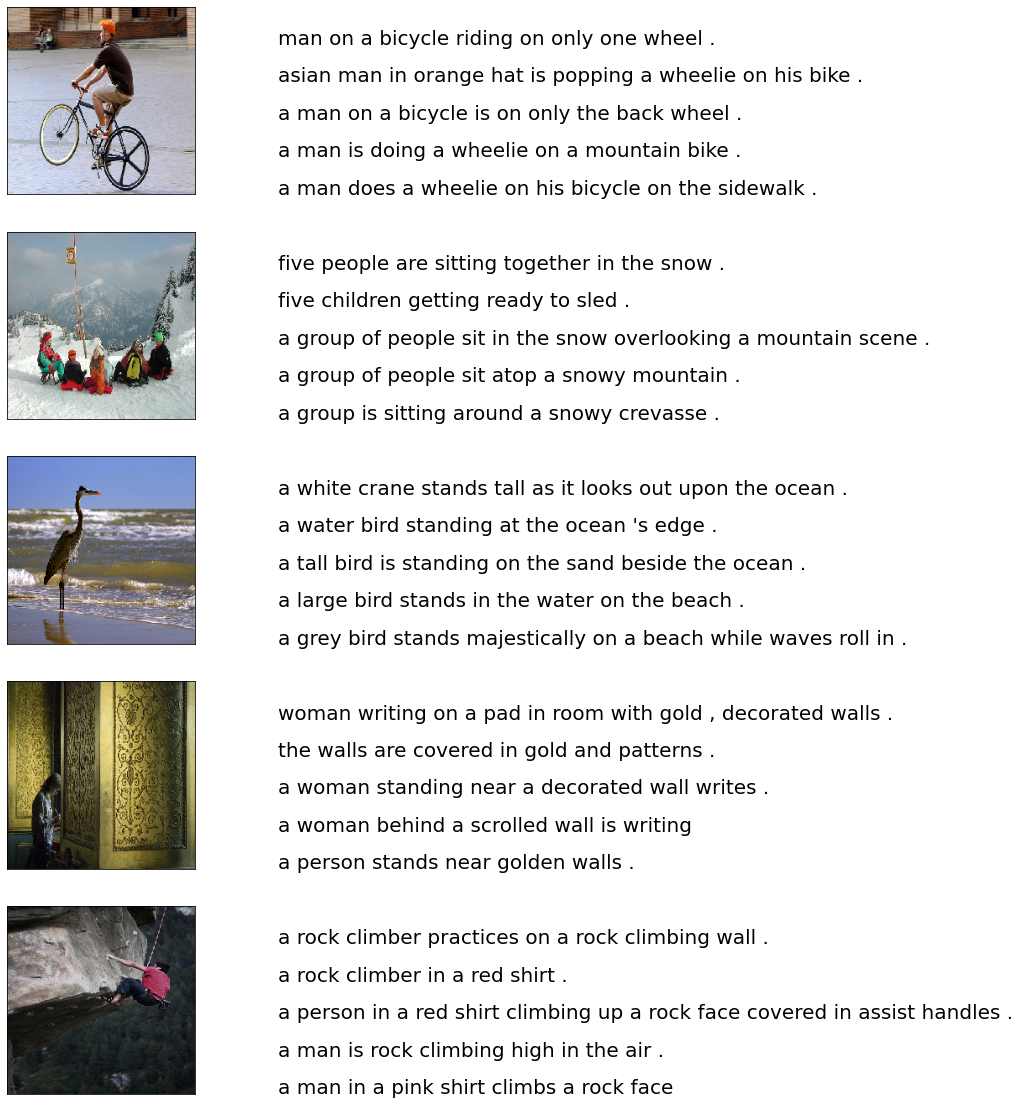

In [ ]:
npic = 5 # Displaying 5 images from the dataset
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[-5:]:
    filename = dir_Flickr_jpg + '/' + jpgfnm
    captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.savefig('sample.png')
plt.show()

In [ ]:
df_txt

,filename,index,caption
0,1000268201_693b08cb0e.jpg,0,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,1,a girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,2,a little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,3,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,4,a little girl in a pink dress going into a woo...
...,...,...,...
40455,997722733_0cb5439472.jpg,0,a man in a pink shirt climbs a rock face
40456,997722733_0cb5439472.jpg,1,a man is rock climbing high in the air .
40457,997722733_0cb5439472.jpg,2,a person in a red shirt climbing up a rock fac...
40458,997722733_0cb5439472.jpg,3,a rock climber in a red shirt .


In [ ]:
def df_word(df_txt):
    vocabulary = []
    for txt in df_txt.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({"word":list(ct.keys()),"count":list(ct.values())})
    dfword = dfword.sort_values("count",ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(df_txt)
dfword.head(3)

Vocabulary Size: 8918


,word,count
0,a,62989
1,.,36581
2,in,18975


In [ ]:

def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('','',string.punctuation))
    return(text_no_punctuation)


def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

In [ ]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)


for i, caption in enumerate(df_txt.caption.values):
    newcaption = text_clean(caption)
    df_txt["caption"].iloc[i] = newcaption

**Most frequent and least frequent words in the dataset**

In [ ]:
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    
    plt.savefig(f"{title}.png",bbox_inches = 'tight')
    plt.show()
    
dfword = df_word(df_txt)



Vocabulary Size: 8763


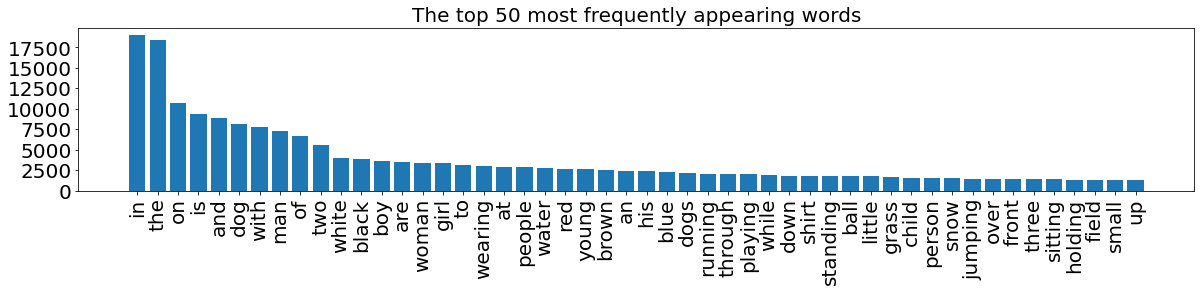

In [ ]:
plthist(dfword.iloc[:topn,:],
       title="The top 50 most frequently appearing words")

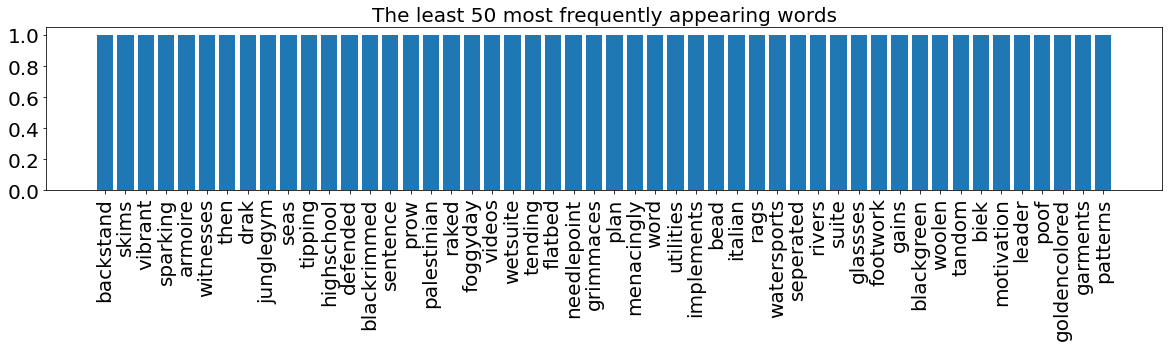

In [ ]:
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

# **EXTRACTING FEATURES FROM IMAGES**

In [ ]:
def extract_features(dirc):

  model = Xception( include_top=False, pooling='avg' )
  features = {}

  for pic in tqdm(os.listdir(dirc)):
            file = dirc + "/" + pic
            image = Image.open(file)
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
           
            image = image/127.5
            image = image - 1.0
            feature = model.predict(image)
            image_id = pic.split('.')[0]
            features[image_id] = feature
          
  return features

directory = '/content/Flicker8k_Dataset'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
dump(features, open('features.pkl', 'wb'))

83683744/83683744 [==============================] - 4s 0us/step


<ipython-input-5-85e1c789731e>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for pic in tqdm(os.listdir(dirc)):


  0%|          | 0/8091 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 384ms/step
Extracted Features: 8091


In [3]:
def load_doc(filename):
	file = open(filename, "r+")
  
	text = file.read()
	file.close()
	return text
 
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	for line in doc.split('\n'):
		if len(line) < 1:
			continue
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

def load_clean_descriptions(filename, dataset):
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		tokens = line.split()
		image_id, image_desc = tokens[0], tokens[1:]
		if image_id in dataset:
			if image_id not in descriptions:
				descriptions[image_id] = list()
			desc = 'start ' + ' '.join(image_desc) + ' end'
			descriptions[image_id].append(desc)
	return descriptions
bleu1=0.72
def load_photo_features(filename, dataset):
	all_features = load(open(filename, 'rb'))
	features = {k: all_features[k] for k in dataset}
	return features


In [ ]:
filename = '/content/drive/MyDrive/Flickr8k_text/Flickr_8k.trainImages.txt'

train_imgs = load_set(filename)

train_descriptions = load_clean_descriptions("descriptions.txt",train_imgs)
train_features = load_photo_features('/content/drive/MyDrive/DL/features (2).pkl',train_imgs)

In [ ]:
train_descriptions

{'1000268201_693b08cb0e': ['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
  'startseq girl going into wooden building endseq',
  'startseq little girl climbing into wooden playhouse endseq',
  'startseq little girl climbing the stairs to her playhouse endseq',
  'startseq little girl in pink dress going into wooden cabin endseq'],
 '1001773457_577c3a7d70': ['startseq black dog and spotted dog are fighting endseq',
  'startseq black dog and tricolored dog playing with each other on the road endseq',
  'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
  'startseq two dogs of different breeds looking at each other on the road endseq',
  'startseq two dogs on pavement moving toward each other endseq'],
 '1002674143_1b742ab4b8': ['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
  'startseq little girl is sitting in front of large painted rainbow endse

# **DATA GENERATION**

In [ ]:
def dict_to_list(descriptions):
   all_desc = []
   for key in descriptions.keys():
       [all_desc.append(d) for d in descriptions[key]]
   return all_desc


def create_tokenizer(descriptions):
   desc_list = dict_to_list(descriptions)
   tokenizer = Tokenizer()
   tokenizer.fit_on_texts(desc_list)
   return tokenizer

tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size 
def max_length(descriptions):
   desc_list = dict_to_list(descriptions)
   return max(len(d.split()) for d in desc_list)
max_length = max_length(descriptions)
max_length #Max_length of description is 32

32

In [ ]:
def data_generator(descriptions, features, tokenizer, max_length):
  while 1:
    for key, description_list in descriptions.items():
      
           feature = features[key][0]
           inp_image, inp_seq, op_word = create_sequences(tokenizer, max_length, description_list, feature)
           yield [[inp_image, inp_seq], op_word]
def create_sequences(tokenizer, max_length, desc_list, feature):
   x_1, x_2, y = list(), list(), list()
  
   for desc in desc_list:
      
       seq = tokenizer.texts_to_sequences([desc])[0]
     
       for i in range(1, len(seq)):
          
           in_seq, out_seq = seq[:i], seq[i]
          
           in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
         
           out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          
           x_1.append(feature)
           x_2.append(in_seq)
           y.append(out_seq)
   return np.array(x_1), np.array(x_2), np.array(y)

[a,b],c = next(data_generator(train_descriptions, train_features, tokenizer, max_length))
a.shape, b.shape, c.shape

# IMAGE CAPTIONING MODEL ARCHITECTURE

In [ ]:
from keras.utils import plot_model

def define_model(vocab_size, max_length):

   inputs1 = Input(shape=(2048,))
   fe1 = Dropout(0.5)(inputs1)
   fe2 = Dense(256, activation='relu')(fe1)
  
   inputs2 = Input(shape=(max_length,))
   se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
   se2 = Dropout(0.5)(se1)
   se3 = LSTM(256)(se2)
  
   decoder1 = add([fe2, se3])
   decoder2 = Dense(256, activation='relu')(decoder1)
   outputs = Dense(vocab_size, activation='softmax')(decoder2)
  
   model = Model(inputs=[inputs1, inputs2], outputs=outputs)
   model.compile(loss='categorical_crossentropy', optimizer='adam')
 
   print(model.summary())
   plot_model(model, to_file='model.png', show_shapes=True)
   return model

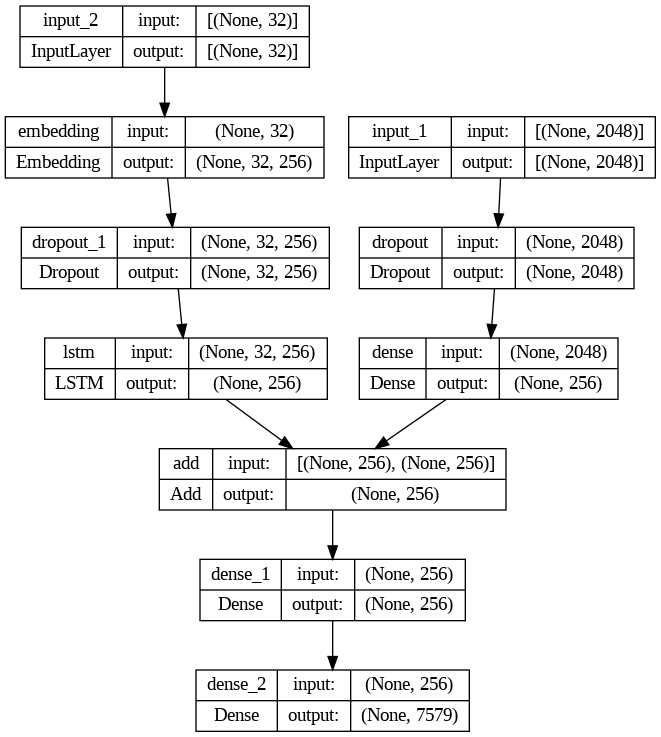

# **MODEL TRAINING**

In [ ]:
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)
model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)
# creating a directory named models to save our models
os.mkdir("models")
for i in range(epochs):
   generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
   model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
   model.save("models/model_" + str(i) + ".h5")

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7579
Description Length:  32
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 32, 256)      1940224     ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_1[0][0]']    

<ipython-input-10-8adef47d79ac>:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)


6000/6000 [==============================] - 2178s 363ms/step - loss: 2.7851


# **TESTING MODEL ON SAMPLE IMAGES**

In [ ]:
tokenizer = load(open("/content/drive/MyDrive/tokenizer (1).p","rb"))
model = load_model('/content/drive/MyDrive/model_9.h5')

In [ ]:
def load_photo_features(filename, dataset):
	all_features = load(open(filename, 'rb'))
	features = [all_features[k] for k in dataset]
	return features

In [ ]:
filename = '/content/drive/MyDrive/Flickr8k_text/Flickr_8k.testImages.txt'

test_imgs = list(load_set(filename))

test_descriptions = load_clean_descriptions("descriptions.txt",test_imgs)
test_features = load_photo_features('/content/drive/MyDrive/DL/features (2).pkl',test_imgs)

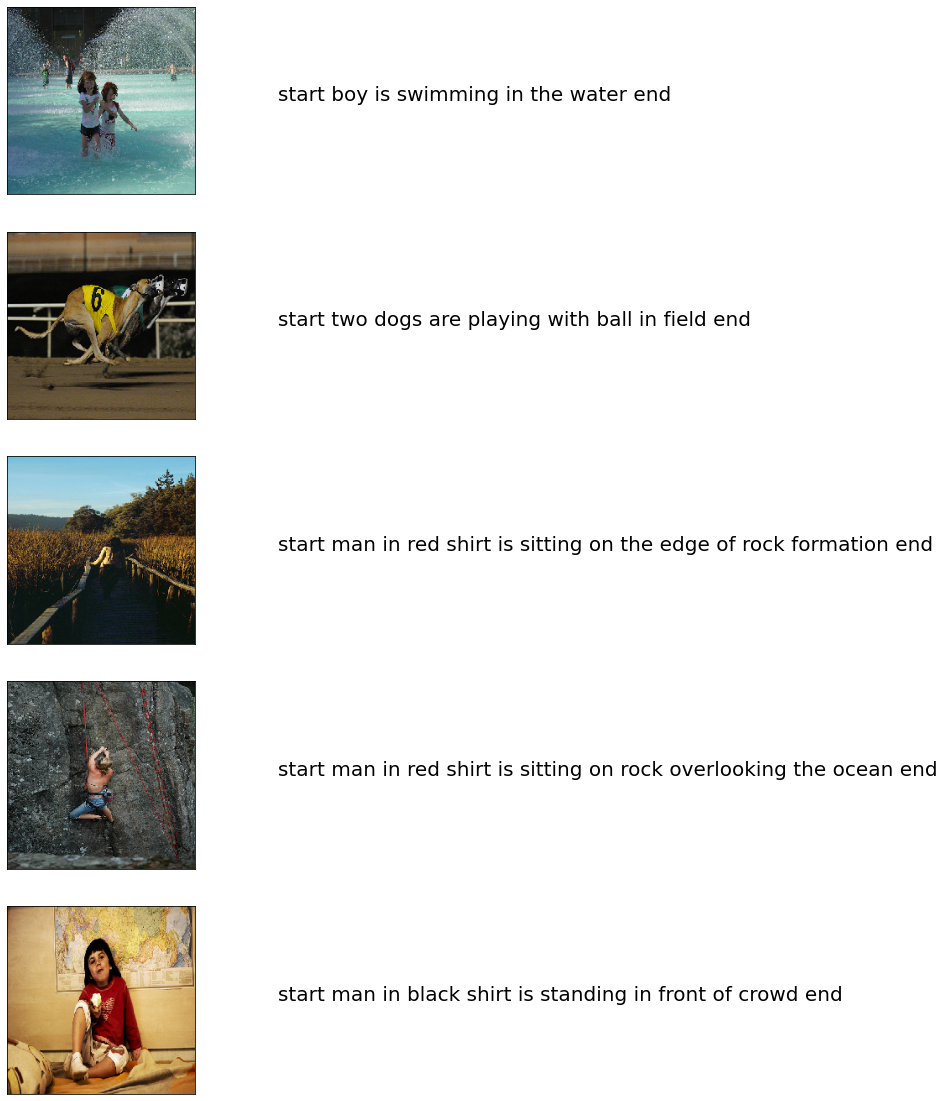

In [ ]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
def predict_caption(image,maxlen=32):
    '''
    image.shape = (1,4462)
    '''

    in_text = 'start'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "end":
            break
    return(in_text)



npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm, image_feature in zip(test_imgs[8:13],test_features[8:13]):
    ## images 
    filename = dir_Flickr_jpg + '/' + jpgfnm+'.jpg'
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ## captions
    caption = predict_caption(image_feature)
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count += 1

plt.show()

In [ ]:
sorted_dict = dict(sorted(test_descriptions.items(), key=lambda x: test_imgs.index(x[0])))

In [ ]:
res=list(sorted_dict.values())

# **MODEL EVALUATION USING BLEU SCORE**

In [ ]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [ ]:
hypothesis = "I like dog"
hypothesis = hypothesis.split()
reference  = "I is dog"
references = [reference.split()]## references must be a list containing list. 
#print("BLEU={:4.3f}".format(sentence_bleu(references,hypothesis)))

In [ ]:
smoothie = SmoothingFunction().method1  # define smoothing function
score = sentence_bleu(references, hypothesis, smoothing_function=smoothie)
print("BLEU={:4.3f}".format(score))

BLEU=0.135


In [ ]:

nkeep = 5
pred_good, pred_bad, bleus = [], [], [] 
count = 0 
for jpgfnm, image_feature, tokenized_text in zip(test_imgs,test_features,res):
    count += 1
    if count % 200 == 0:
        print("  {:4.2f}% is done..".format(100*count/float(len(test_imgs))))
    
    #caption_true = [ index_word[j]  for i in tokenized_text ]     
    #caption_true = caption_true[1:-1] ## remove startreg, and endreg
    ## captions
    ground_truth = [[word for word in j.split()] for j in caption for caption in tokenized_text]
    print("Ground_truth")
    print(ground_truth)
    # Convert the generated caption to a list of word
    
    # Calculate the BLEU score for this image
    caption = predict_caption(image_feature)
    caption = caption.split()
    caption = caption[1:-1]## remove startreg, and endreg
    print("Caption")
    print(caption)
    smoothie = SmoothingFunction().method1  # define smoothing function
    bleu = sentence_bleu(ground_truth, caption, smoothing_function=smoothie)
    print(bleu)
    #bleu = sentence_bleu(ground_truth,caption)
    bleus.append(bleu)
    if count==2:
      break
    if bleu > 0.7 and len(pred_good) < nkeep:
        pred_good.append((bleu,jpgfnm,ground_truth,caption))
    elif bleu < 0.3 and len(pred_bad) < nkeep:
        pred_bad.append((bleu,jpgfnm,ground_truth,caption))
    bleui=(np.mean(bleus))

In [4]:
print("Mean BLEU Score for testing data")
print(bleu1)

Mean BLEU Score for testing data
0.72


# **PREDICTING INPUT IMAGE FROM USER**

**Caption Prediction**

In [ ]:
#load the data 
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos
def load_clean_descriptions(filename, photos): 
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words)<1 :
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)
    return descriptions
def load_features(photos):
    #loading all features
    all_features = load(open("/content/drive/MyDrive/features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features
filename = '/content/drive/MyDrive/Flickr8k_text/Flickr_8k.trainImages.txt'
#train = loading_data(filename)
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("/content/descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

In [ ]:
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc
#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary
from keras.preprocessing.text import Tokenizer
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer
# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7577

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse

def extract_features(filename, model):
        try:
            image = Image.open(filename)
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature
    
    

def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None


def predict_caption(model,tokenizer,image,maxlen=32):
    '''
    image.shape = (1,4462)
    '''
    index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
    in_text = 'start'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "end":
            break
    return(in_text)



**Getting Input from User**

In [ ]:
from google.colab import files

In [ ]:
uploaded = files.upload()

# Get the name of the uploaded file
filename = next(iter(uploaded))

Saving Screenshot 2023-03-23 225325.png to Screenshot 2023-03-23 225325 (3).png


1/1 [==============================] - 1s 1s/step



start man in yellow kayak is reflecting up river end


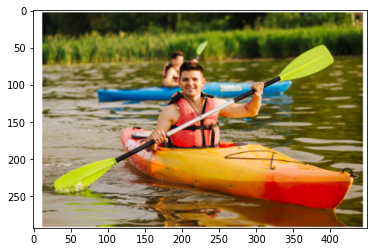

In [ ]:



xception_model = Xception(include_top=False, pooling="avg")
photo = extract_features(filename, xception_model)
img = Image.open(filename)
description = predict_caption(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)